### 0. Notebook setup

In [1]:
COLAB = False # Set this to True if you want to install the libraries and clone the repository in Colab
USE_DOTENV = True # Set this to False if you don't have a .env file for storing environment variables

if COLAB:
    USE_DOTENV = False
    dotenv_path = None
    from google.colab import userdata
    colab_secrets = {'HF_TOKEN': userdata.get('HF_TOKEN'), 'HF_TOKEN_WRITE': userdata.get('HF_TOKEN_WRITE')}
    !pip install datasets
    !git clone https://github.com/reddgr/zero-shot-text-classification
    import os
    os.system("mv zero-shot-text-classification zs_tc")

if USE_DOTENV: 
    COLAB=False
    dotenv_path = "../../../../../apis/.env"
    colab_secrets = None

from transformers import pipeline, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf
import random
from datasets import load_dataset, Dataset
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import sys
import os
import torch
import textwrap
from IPython.display import clear_output
import matplotlib.pyplot as plt

if COLAB:
    import sys
    sys.path.append("./zs_tc/src")
    import env_options, nli_labeling_widget as labeling_widget, text_classification_functions as tcf, lmsys_dataset_handler as lmsys
else:
    import sys
    sys.path.append("./src")
    import text_classification_functions as tcf
    import env_options
    import lmsys_dataset_handler as lmsys
    import nli_finetuning_utils

hf_token, hf_token_write, openai_api_key = env_options.check_env(colab=COLAB, use_dotenv=USE_DOTENV, 
                                                 dotenv_path=dotenv_path, colab_secrets=colab_secrets)


Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.2.2
Transformers version: 4.44.2
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Version: 12.1
FlashAttention available: True
Retrieved token(s) from .env file
Using HuggingFace token: hf_M*****************************IASJ
Using HuggingFace write token: hf_u*****************************Xipx
Using OpenAI token: sk-p************************************************************************************************************************************************************_5sA


In [2]:
### DEBUG ###
import importlib
importlib.reload(nli_finetuning_utils)
### DEBUG ###

<module 'nli_finetuning_utils' from 'c:\\Users\\david\\Documents\\git\\zero-shot-text-classification\\./src\\nli_finetuning_utils.py'>

## Preparing test datasets

Loading the Test dataset

In [2]:
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
print("Labels: ",test_dataset_dict["test"].features["label"]._str2int)
entailments_test_dataset_df = test_dataset_df[test_dataset_df['label'] == 2]
display(entailments_test_dataset_df.head(3))
print(f'... {len(entailments_test_dataset_df)} records ...')
display(entailments_test_dataset_df.tail(3))

Labels:  {'contradiction': 0, 'neutral': 1, 'entailment': 2}


,text,category,label
5,I wanna have a conversation in german to practice,language,2
7,What you think about Belarus?,general knowledge,2
9,What does LLaMA means?,technology,2


... 216 records ...


,text,category,label
408,Write some html code that will play a graphics...,coding,2
412,"How do you think, what can be the potential ne...",ai,2
414,When I was 6 my sister was half my age. Now I’...,riddle,2


### Define category lists for test metrics

10 categories:

In [3]:
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_filter = 10
print(f'Top {top_n_filter} prompt categories (Test split):\n{category_counts.head(top_n_filter)}')
# We exclude "general knowledge" from the tests given the high ambiguity of the category
category_counts = category_counts[category_counts.index != 'general knowledge']
top_categories = category_counts.head(top_n_filter).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
print(f'{len(test_entailments_df)} records for testing {top_n_filter} categories')
test_entailments_dataset = Dataset.from_pandas(test_entailments_df)
print(test_entailments_dataset)
print(top_categories.to_list())

Top 10 prompt categories (Test split):
category
coding               39
technology           27
writing              21
language             20
science              19
business             18
popular culture      11
role play            10
general knowledge     9
riddle                8
Name: count, dtype: int64
178 records for testing 10 categories
Dataset({
    features: ['text', 'category', 'label', '__index_level_0__'],
    num_rows: 178
})
['coding', 'technology', 'writing', 'language', 'science', 'business', 'popular culture', 'role play', 'riddle', 'finance']


Grouped categories:

In [4]:
test_df_grouped = entailments_test_dataset_df.copy()
test_df_grouped.loc[test_df_grouped['category'] == 'business', 'category'] = 'business and finance'
test_df_grouped.loc[test_df_grouped['category'] == 'finance', 'category'] = 'business and finance'
test_df_grouped.loc[test_df_grouped['category'] == 'language', 'category'] = 'language and writing'
test_df_grouped.loc[test_df_grouped['category'] == 'writing', 'category'] = 'language and writing'
test_df_grouped.loc[test_df_grouped['category'] == 'popular culture', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'music', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'entertainment', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'technology', 'category'] = 'technology and ai'
test_df_grouped.loc[test_df_grouped['category'] == 'ai', 'category'] = 'technology and ai'
category_counts = test_df_grouped['category'].value_counts()
top_n_display = 10
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 6
top_grouped_categories = category_counts.head(top_n_categories).index
test_entailments_grouped = test_df_grouped[test_df_grouped['category'].isin(top_grouped_categories)]
print(f'{len(test_entailments_grouped)} records for testing {top_n_categories} category groups')
print(top_grouped_categories.to_list())

Top 10 prompt categories:
category
language and writing         41
coding                       39
technology and ai            32
business and finance         23
science                      19
culture and entertainment    15
role play                    10
general knowledge             9
riddle                        8
philosophy                    4
Name: count, dtype: int64
169 records for testing 6 category groups
['language and writing', 'coding', 'technology and ai', 'business and finance', 'science', 'culture and entertainment']


## Tests metrics for current model

No need to run these cells if there's no new version of the model

### 10-category test (current model)

Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft:   0%|          | 0/171 [00:00<?, ?it/s]c:\Users\david\anaconda3\Lib\site-packages\transformers\models\bart\modeling_bart.py:496: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft:   6%|▋         | 11/171 [00:01<00:29,  5.36it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 171/171 [00:31<00:00,  5.36it/s]


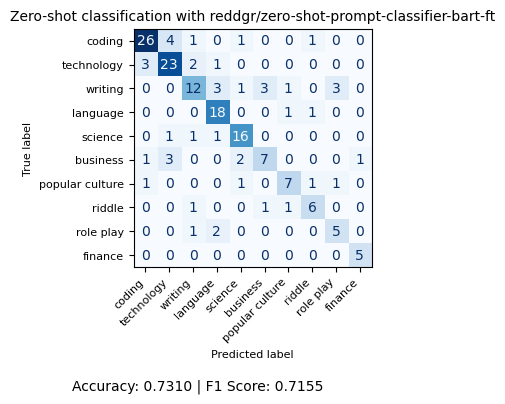

In [5]:
nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier_10 = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
zs_test_metrics = zs_classifier_10.test_zs_predictions(test_entailments_df)

### 6 grouped categories test (current model)

Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 160/160 [00:22<00:00,  7.03it/s]


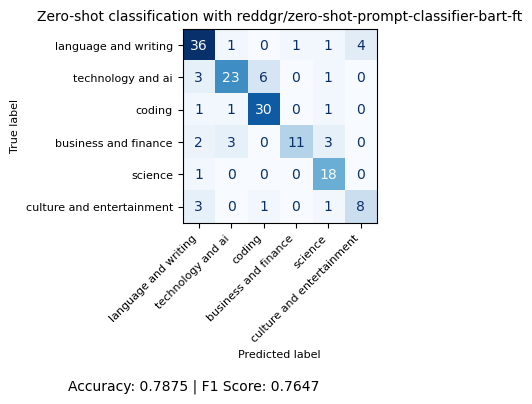

In [6]:
nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier_grouped = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_grouped_categories)
zs_test_metrics_grouped = zs_classifier_grouped.test_zs_predictions(test_entailments_grouped)

## Finetuning

Loading the Train split:

In [6]:
SAMPLING = False
dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
hf_dataset = dataset_dict["train"]

if SAMPLING:
    n_samples = 1000
    RANDOM_SAMPLING = True
    if not RANDOM_SAMPLING:
        # SAMPLING ONLY LATEST n_samples RECORDS
        total_samples = len(hf_dataset)
        hf_dataset = dataset_dict["train"].select(range(total_samples - n_samples, total_samples))
    else:
        # SAMPLING RANDOMLY n_samples RECORDS
        hf_dataset = dataset_dict["train"].shuffle().select(range(n_samples))

hf_dataset = hf_dataset.rename_column('category', 'class')

hf_dataset_df = hf_dataset.to_pandas()
print("Labels: ",dataset_dict["train"].features["label"]._str2int)

display(hf_dataset_df.head(3))
print(f'... {len(hf_dataset_df)} records ...')
display(hf_dataset_df.tail(3))

Labels:  {'contradiction': 0, 'neutral': 1, 'entailment': 2}


,text,class,label
0,pretent you're a hotel manager who received th...,role play,2
1,Write a single dot\n,coding,0
2,Write an article about the Applications of 2-E...,language,1


... 1705 records ...


,text,class,label
1702,Hello - please generate python code for buildi...,riddle,0
1703,If I were to create a POC for a company-wide i...,technology,2
1704,If I were to create a POC for a company-wide i...,riddle,0


Tokenizing and formatting the dataset:

In [7]:
nli_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli', clean_up_tokenization_spaces=True)
nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli', clean_up_tokenization_spaces=True)
print(f"Loaded NLI model with head:\n{nli_model.classification_head.out_proj}\n{nli_model.config.id2label}")

# top_categories =['technology', 'language', 'coding', 'science', 'business', 'writing', 'popular culture', 'role play', 'riddle', 'general knowledge']
# Instantiate the NLIModelFineTuner class
fine_tuner = nli_finetuning_utils.NLIModelFineTuner(hf_dataset, top_grouped_categories, nli_model, nli_tokenizer)

# Tokenize and format the dataset
template = "This example is a {} prompt."
max_length = 128
eval_proportion = 0.3

train_dataset, eval_dataset, full_dataset = fine_tuner.tokenize_and_format_nli_dataset(template, max_length, eval_proportion)
print(f"Train dataset: {len(train_dataset)}, Eval dataset: {len(eval_dataset)}")
print(top_grouped_categories)
print("\nInput sentence example:")
random_index = random.randint(0, len(train_dataset))
print(train_dataset.to_pandas()['input_sentence'].iloc[random_index])
print(f"Label: {train_dataset.to_pandas()['labels'].iloc[random_index]}", 
      f"({dataset_dict['train'].features['label']._int2str[train_dataset.to_pandas()['labels'].iloc[random_index]]})")

Loaded NLI model with head:
Linear(in_features=1024, out_features=3, bias=True)
{0: 'contradiction', 1: 'neutral', 2: 'entailment'}
Train dataset: 1193, Eval dataset: 512
Index(['language and writing', 'coding', 'technology and ai',
       'business and finance', 'science', 'culture and entertainment'],
      dtype='object', name='category')

Input sentence example:
<prompt>"Tch...I won't... no... no!! ahhhh!" My barrier started to break, and in the end I was blown off to the air. Falling almost unconsciously before the civilians, my clothes is broken by the shockwave, and large part of my shinny skin is exposed.</prompt> This example is a ai prompt.
Label: 0 (contradiction)


#### Fine-tuning:

Loading model and tokenizer:

In [8]:
model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli', clean_up_tokenization_spaces=True)
# model = AutoModelForSequenceClassification.from_pretrained('reddgr/zero-shot-prompt-classifier-bart-ft', clean_up_tokenization_spaces=True)
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli', clean_up_tokenization_spaces=True)
print("model_type: ",model.config.model_type)
print("model_input_names: ",tokenizer.model_input_names)
print("num_labels: ",model.config.num_labels)
print("max_position_embeddings: ",getattr(model.config, "max_position_embeddings", None))

model_type:  bart
model_input_names:  ['input_ids', 'attention_mask']
num_labels:  3
max_position_embeddings:  1024


In [9]:
learning_rate=4e-6 # 1 e-5 # 5e-6
n_epochs=2.5
bsize=32 # 32 if you have the memory
t_max=8 ### 10
# trainer = fine_tuner.fine_tune(output_dir="./models", epochs=n_epochs, batch_size=bsize, learning_rate=learning_rate)
trainer, train_results = fine_tuner.fine_tune_with_cosine_annealing("./models", n_epochs, bsize, learning_rate, t_max)

Using device: cuda:0
Fine-tuning in progress...


  0%|          | 0/95 [00:00<?, ?it/s]

Last learning rate: 4e-06


c:\Users\david\anaconda3\Lib\site-packages\transformers\models\bart\modeling_bart.py:496: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation param


Epoch 1.0 complete.


  0%|          | 0/64 [00:00<?, ?it/s]

{'eval_loss': 0.7536845207214355, 'eval_runtime': 58.8704, 'eval_samples_per_second': 8.697, 'eval_steps_per_second': 1.087, 'epoch': 1.0}
Last learning rate: 5.85786437626907e-07


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-defau


Epoch 2.0 complete.


  0%|          | 0/64 [00:00<?, ?it/s]

{'eval_loss': 0.7143388986587524, 'eval_runtime': 59.4556, 'eval_samples_per_second': 8.611, 'eval_steps_per_second': 1.076, 'epoch': 2.0}
Last learning rate: 2.00000000000002e-06


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-defau


Epoch 2.5 complete.


  0%|          | 0/64 [00:00<?, ?it/s]

{'eval_loss': 0.7176371812820435, 'eval_runtime': 56.2852, 'eval_samples_per_second': 9.097, 'eval_steps_per_second': 1.137, 'epoch': 2.5}
{'train_runtime': 1712.3307, 'train_samples_per_second': 1.742, 'train_steps_per_second': 0.055, 'train_loss': 0.7272672151264391, 'epoch': 2.5}
Fine-tuning complete. Model saved to ./models.
Last checkpoint 95


In [10]:
for obj in trainer.state.log_history:
    print(obj)
metrics = train_results.metrics
print(f"Train metrics: {metrics}")
print(trainer.state.global_step)

{'eval_loss': 0.7536845207214355, 'eval_runtime': 58.8704, 'eval_samples_per_second': 8.697, 'eval_steps_per_second': 1.087, 'epoch': 1.0, 'step': 38}
{'eval_loss': 0.7143388986587524, 'eval_runtime': 59.4556, 'eval_samples_per_second': 8.611, 'eval_steps_per_second': 1.076, 'epoch': 2.0, 'step': 76}
{'eval_loss': 0.7176371812820435, 'eval_runtime': 56.2852, 'eval_samples_per_second': 9.097, 'eval_steps_per_second': 1.137, 'epoch': 2.5, 'step': 95}
{'train_runtime': 1712.3307, 'train_samples_per_second': 1.742, 'train_steps_per_second': 0.055, 'total_flos': 807104258174844.0, 'train_loss': 0.7272672151264391, 'epoch': 2.5, 'step': 95}
Train metrics: {'train_runtime': 1712.3307, 'train_samples_per_second': 1.742, 'train_steps_per_second': 0.055, 'total_flos': 807104258174844.0, 'train_loss': 0.7272672151264391, 'epoch': 2.5}
95


In [11]:
checkpoint_step = trainer.state.global_step
print(f"Last checkpoint step: {checkpoint_step}")

Last checkpoint step: 95


MANUAL SAVE:

Save the model (if not saved already):

In [12]:
output_dir = "./models/checkpoint-evloss717"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to: {output_dir}")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


Model and tokenizer saved to: ./models/checkpoint-evloss717


Load saved model:

In [13]:
# checkpoint_step = 81
checkpoint_step = trainer.state.global_step
checkpoint_step = 'evloss717'
# checkpoint_step = 'evloss76' # best
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(f"./models/checkpoint-{checkpoint_step}")
print(f"Loaded model from: ./models/checkpoint-{checkpoint_step}")

Loaded model from: ./models/checkpoint-evloss717


### Grouped categories test

sequence: What is the last day to pay the IRC for a componay in portgual?
labels: ['business and finance', 'coding', 'technology and ai', 'culture and entertainment', 'language and writing', 'science']
scores: [0.513, 0.138, 0.128, 0.113, 0.071, 0.037]


Zero-shot classification with ./models/checkpoint-evloss76: 100%|██████████| 169/169 [01:09<00:00,  2.43it/s]


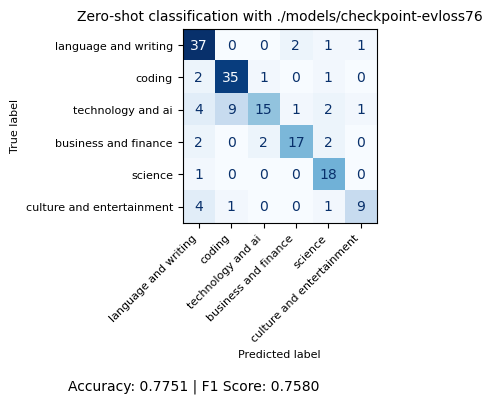

In [16]:
finetuned_model_path=f"./models/checkpoint-{checkpoint_step}"
tokenizer_path="facebook/bart-large-mnli"
# zs_classifier_finetuned = tcf.ZeroShotClassifier(finetuned_model_path, tokenizer_path, top_categories)
zs_classifier_finetuned = tcf.ZeroShotClassifier(finetuned_model_path, tokenizer_path, top_grouped_categories)
text_sample = test_entailments_df.sample(1, random_state=38).text.values[0]
result = zs_classifier_finetuned.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
for key, value in result.items():
    print(f"{key}: {value}")

zs_test_metrics_ft_grouped = zs_classifier_finetuned.test_zs_predictions(test_entailments_grouped)

### 10-category test

c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Zero-shot classification with ./models/checkpoint-evloss717:   6%|▌         | 11/178 [00:11<03:26,  1.24s/it]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Zero-shot classification with ./models/checkpoint-evloss717: 100%|██████████| 178/178 [04:07<00:00,  1.39s/it]


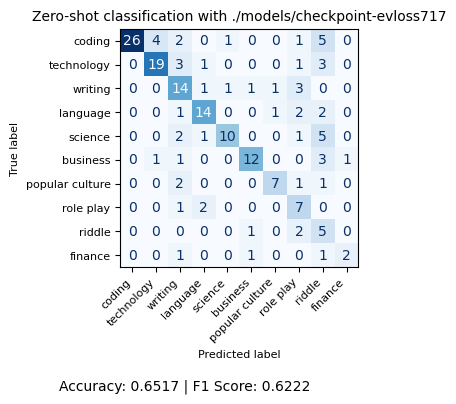

In [14]:
finetuned_model_path=f"./models/checkpoint-{checkpoint_step}"
tokenizer_path="facebook/bart-large-mnli"
zs_classifier_finetuned = tcf.ZeroShotClassifier(finetuned_model_path, tokenizer_path, top_categories)
zs_test_metrics_ft = zs_classifier_finetuned.test_zs_predictions(test_entailments_df)

In [15]:
zs_test_metrics_ft.get('detailed_results')
results_df = pd.DataFrame(zs_test_metrics_ft['detailed_results'])
display(results_df.sample(5))
results_df.to_csv('csv/10c-test.csv', index=False)

,text,category,label,predicted_class
37,"what is an equivalent term for ""day to day con...",language,2,language
85,IS LMSYS associated with any company or organi...,business,2,business
297,Rewrite what I asked you to rewrite,writing,2,writing
55,What's the sum of all integer values from 2 to...,riddle,2,riddle
119,"who are the authors of the paper ""All Weather ...",technology,2,writing


### Other tests

In [16]:
base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)

nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, base_model_path, top_categories)
zs_classifier_finetuned = tcf.ZeroShotClassifier(finetuned_model_path, base_model_path, top_categories)

# text_sample = test_entailments_df.sample(1).text.values[0]
text_sample = "I'm twice the age you were when i was your age. How old are we?"
ft_result = zs_classifier_finetuned.classify_text(text_sample, multi_label=False)
base_result = base_classifier.classify_text(text_sample, multi_label=False)
current_result = zs_classifier.classify_text(text_sample, multi_label=False)
clear_output(wait=True)

print("Classification with base model:")
for key, value in base_result.items():
    print(f"{key}: {value}")

print("\nClassification with model fine-tuned in this session:")
for key, value in ft_result.items():
    print(f"{key}: {value}")


print("\nClassification with most recent fine-tuned model:")
for key, value in current_result.items():
    print(f"{key}: {value}")

Classification with base model:
sequence: I'm twice the age you were when i was your age. How old are we?
labels: ['riddle', 'language', 'role play', 'writing', 'popular culture', 'science', 'business', 'technology', 'finance', 'coding']
scores: [0.515, 0.119, 0.075, 0.073, 0.052, 0.04, 0.039, 0.036, 0.026, 0.026]

Classification with model fine-tuned in this session:
sequence: I'm twice the age you were when i was your age. How old are we?
labels: ['riddle', 'role play', 'language', 'writing', 'science', 'popular culture', 'business', 'finance', 'technology', 'coding']
scores: [0.229, 0.167, 0.123, 0.1, 0.091, 0.088, 0.067, 0.054, 0.047, 0.034]

Classification with most recent fine-tuned model:
sequence: I'm twice the age you were when i was your age. How old are we?
labels: ['riddle', 'role play', 'science', 'business', 'popular culture', 'writing', 'language', 'finance', 'technology', 'coding']
scores: [0.24, 0.19, 0.101, 0.091, 0.089, 0.067, 0.066, 0.059, 0.055, 0.041]


Accuracy by labeled category:

In [17]:
zs_test_metrics_ft.get('detailed_results')
results_df = pd.DataFrame(zs_test_metrics_ft['detailed_results'])
results_by_category = results_df.groupby(['category', 'predicted_class']).size().unstack(fill_value=0)
accuracy_by_category = results_df.groupby('category').apply(lambda x: (x['category'] == x['predicted_class']).mean())

print("\nAccuracy by category:")
for category in top_categories:
    print(f"{category:20} {accuracy_by_category[category]:.3f}")

print("\nResults sample:")
display(results_df.sample(5))


Accuracy by category:
coding               0.846
technology           0.704
writing              0.810
language             0.750
science              0.842
business             0.722
popular culture      0.636
role play            0.700
riddle               0.750
finance              0.800

Results sample:


,text,category,label,predicted_class
332,how many companies are included in each of tho...,business,2,business
311,Give me some grammar advice on this: “ Earlier...,language,2,language
212,Hey! Can you please explain how chatgpt works?,technology,2,technology
136,Which is the maximum fitness for an individual...,coding,2,science
222,Convert this text to JSON instruction format: ...,coding,2,coding


In [19]:
zs_test_metrics_ft.get('detailed_results')
results_df = pd.DataFrame(zs_test_metrics_ft['detailed_results'])
display(results_df.sample(5))
results_df.to_csv('csv/10c-test-ft.csv', index=False)

,text,category,label,predicted_class
215,Hey! Can you please explain how chatgpt works?,technology,2,technology
54,You and I meet for the first time. You are a g...,role play,2,role play
24,Can you make this link have color #353535 only...,coding,2,coding
135,Make a very annoying email with lots of errors...,role play,2,role play
354,how do I change col names of datos_descargados...,coding,2,coding


#### Push to hub:

In [20]:
fine_tuner.model.push_to_hub("reddgr/zero-shot-prompt-classifier-bart-ft", token=hf_token_write)
fine_tuner.tokenizer.push_to_hub("reddgr/zero-shot-prompt-classifier-bart-ft", token=hf_token_write)

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

c:\Users\david\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\david\.cache\huggingface\hub\models--reddgr--zero-shot-prompt-classifier-bart-ft. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some non-default generation parameters are set in the model config. These should go into a Genera

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/reddgr/zero-shot-prompt-classifier-bart-ft/commit/f87341898a2861448dac82257f708419d6294322', commit_message='Upload tokenizer', commit_description='', oid='f87341898a2861448dac82257f708419d6294322', pr_url=None, pr_revision=None, pr_num=None)

## Tensorflow Fine-Tuning

In [ ]:
dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
hf_dataset = dataset_dict["train"]
hf_dataset = hf_dataset.rename_column('category', 'class')
hf_dataset_df = hf_dataset.to_pandas()
print("Labels: ",dataset_dict["train"].features["label"]._str2int)
display(hf_dataset_df.head(3))
print(f'... {len(hf_dataset_df)} records ...')
display(hf_dataset_df.tail(3))

In [ ]:
#from tensorflow.keras import mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)

# Main parameters:
learning_rate=5e-6
n_epochs=5

# Split data into train and eval sets
dataset_split = hf_dataset.train_test_split(test_size=0.5, seed=38)
train_dataset = dataset_split['train']
# This is not the original Test set, but a validation set
# train_test_split generates it with the name 'test', not to be confused with the 'test' split of the original dataset
eval_dataset = dataset_split['test']

tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')
model = TFAutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli', num_labels=3)

def tokenize_function(examples, tokenizer=tokenizer):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# tokenized_dataset = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# Convert tokenized datasets to TensorFlow datasets
train_tf_dataset = tokenized_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=True,
    batch_size=8
)

eval_tf_dataset = tokenized_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=False,
    batch_size=8
)
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

clear_output(wait=True) # remove library warnings
history = model.fit(
    train_tf_dataset,
    validation_data=eval_tf_dataset,
    epochs=n_epochs
)
clear_output(wait=True)

# Plot training and validation losses and accuracies in a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
epochs = range(1, len(history.history['loss']) + 1)

# Plot losses
axes[0].plot(epochs, history.history['loss'], label='Train Loss')
axes[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot accuracies
axes[1].plot(epochs, history.history['accuracy'], label='Train Accuracy')
axes[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

model.save_pretrained("fine-tuned-bart-nli-testing")
tokenizer.save_pretrained("fine-tuned-bart-nli-testing")

# BASIC TEST
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
entailments_test_dataset_df = test_dataset_df[test_dataset_df['label'] == 2]
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_filter = 10
top_categories = category_counts.head(top_n_filter).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
test_entailments_dataset = Dataset.from_pandas(test_entailments_df)

nli_model_path = 'fine-tuned-bart-nli-testing'
zs_classifier_finetuned = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
text_sample = test_entailments_df.sample(1).text.values[0]
result = zs_classifier_finetuned.classify_text(text_sample, multi_label=False)
for key, value in result.items():
    print(f"{key}: {value}")

# TEST PLOT
zs_test_metrics_ft = zs_classifier_finetuned.test_zs_predictions(test_entailments_df)

Load saved model:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('fine-tuned-bart-nli-v0.2')
model = TFAutoModelForSequenceClassification.from_pretrained('fine-tuned-bart-nli-v0.2', num_labels=3)

### Push to hub

In [ ]:
model.push_to_hub("reddgr/zero-shot-prompt-classifier-bart-ft", token=hf_token_write)
tokenizer.push_to_hub("reddgr/zero-shot-prompt-classifier-bart-ft", token=hf_token_write)

## TEST METRICS

In [ ]:
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
entailments_test_dataset_df = test_dataset_df[test_dataset_df['label'] == 2]
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_filter = 10
top_categories = category_counts.head(top_n_filter).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
test_entailments_dataset = Dataset.from_pandas(test_entailments_df)

nli_model_path = 'fine-tuned-bart-nli-v0.2'
zs_classifier_finetuned = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
text_sample = test_entailments_df.sample(1).text.values[0]
result = zs_classifier_finetuned.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
for key, value in result.items():
    print(f"{key}: {value}")

In [ ]:
zs_test_metrics = zs_classifier_finetuned.test_zs_predictions(test_entailments_df)

In [ ]:
text_sample = test_entailments_df.sample(1).text.values[0]
result = zs_classifier_finetuned.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
for key, value in result.items():
    print(f"{key}: {value}")

In [ ]:
text_sample = test_entailments_df.sample(1).text.values[0]
result = zs_classifier.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
for key, value in result.items():
    print(f"{key}: {value}")

In [ ]:
nli_model_path = 'facebook/bart-large-mnli'
zs_classifier_base = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
zs_test_metrics_base = zs_classifier_base.test_zs_predictions(test_entailments_df)

## Extra tests

In [17]:
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_filter = 12 # 12 cats
print(f'Top {top_n_filter} prompt categories (Test split):\n{category_counts.head(top_n_filter)}')
top_categories = category_counts.head(top_n_filter).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
print(f'{len(test_entailments_df)} records for testing {top_n_filter} categories')
test_entailments_dataset = Dataset.from_pandas(test_entailments_df)
print(test_entailments_dataset)
print(top_categories.to_list())

Top 12 prompt categories (Test split):
category
technology           28
coding               26
language             23
science              22
writing              18
business             13
popular culture      11
role play             9
riddle                8
general knowledge     8
ai                    6
finance               5
Name: count, dtype: int64
177 records for testing 12 categories
Dataset({
    features: ['text', 'category', 'label', '__index_level_0__'],
    num_rows: 177
})
['technology', 'coding', 'language', 'science', 'writing', 'business', 'popular culture', 'role play', 'riddle', 'general knowledge', 'ai', 'finance']


Zero-shot classification on test data:: 100%|██████████| 177/177 [07:37<00:00,  2.59s/it]


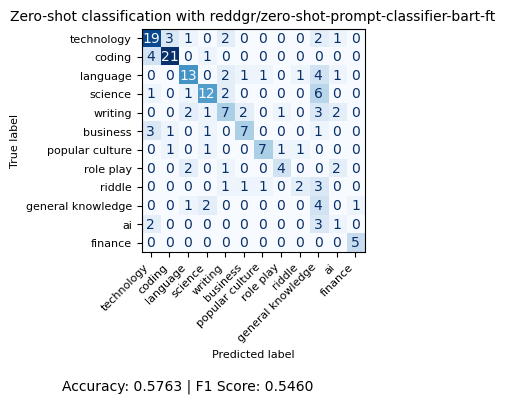

In [18]:
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
zs_test_metrics = zs_classifier.test_zs_predictions(test_entailments_df)

Zero-shot classification on test data:: 100%|██████████| 177/177 [08:43<00:00,  2.96s/it]


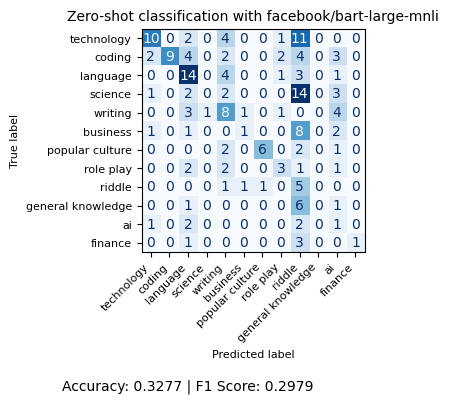

In [31]:
base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, nli_model_path, top_categories)
base_test_metrics = base_classifier.test_zs_predictions(test_entailments_df)

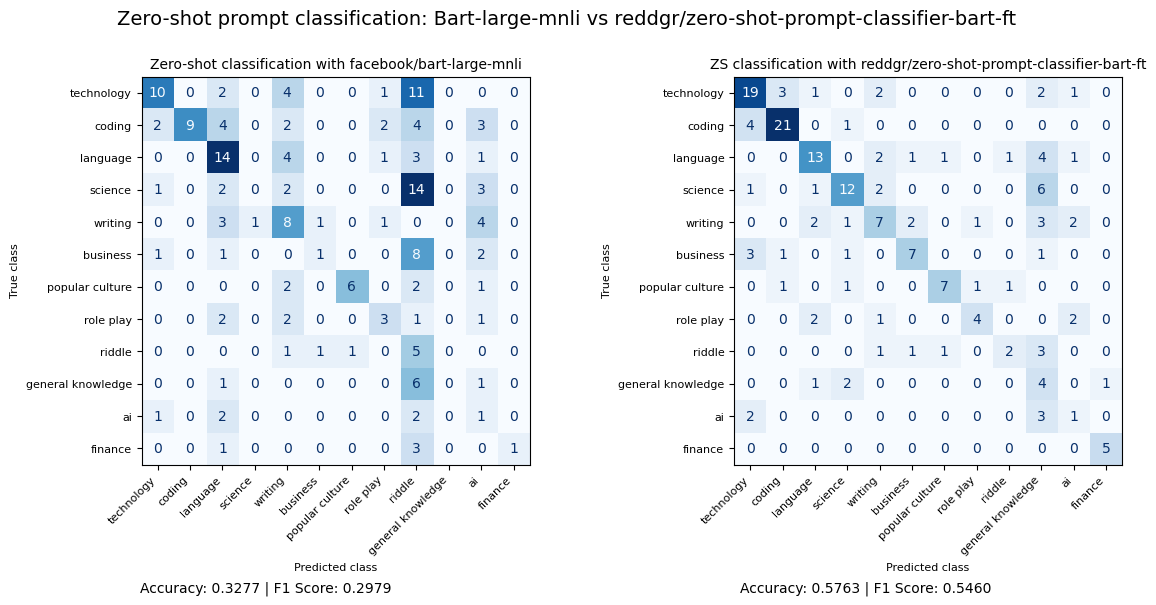

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Zero-shot prompt classification: Bart-large-mnli vs reddgr/zero-shot-prompt-classifier-bart-ft", fontsize=14)

# Plot for base_classifier (left)
disp1 = ConfusionMatrixDisplay(confusion_matrix=base_test_metrics["confusion_matrix"], display_labels=base_classifier.candidate_labels)
disp1.plot(cmap=plt.cm.Blues, ax=axes[0], colorbar=False)
axes[0].set_title(f"Zero-shot classification with {base_model_path}", fontsize=10)
axes[0].set_xlabel("Predicted class", fontsize=8)
axes[0].set_ylabel("True class", fontsize=8)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right", fontsize=8)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=8)

fig.text(
    0.25, 0.01, 
    f"Accuracy: {base_test_metrics['accuracy']:.4f} | F1 Score: {base_test_metrics['f1_score']:.4f}",
    ha="center",
    fontsize=10
)

# Plot for zs_classifier (fine-tuned) (right)
disp2 = ConfusionMatrixDisplay(confusion_matrix=zs_test_metrics["confusion_matrix"], display_labels=zs_classifier.candidate_labels)
disp2.plot(cmap=plt.cm.Blues, ax=axes[1], colorbar=False)
axes[1].set_title(f"ZS classification with {nli_model_path}", fontsize=10)
axes[1].set_xlabel("Predicted class", fontsize=8)
axes[1].set_ylabel("True class", fontsize=8)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right", fontsize=8)
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=8)

fig.text(
    0.75, 0.01, 
    f"Accuracy: {zs_test_metrics['accuracy']:.4f} | F1 Score: {zs_test_metrics['f1_score']:.4f}",
    ha="center",
    fontsize=10
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95]) 
plt.show()